##  Подгружаем необходимые библиотеки

Работа выполнена с помощью Python 3.6.9.

In [1]:
from platform import python_version

print(python_version())

3.6.9


In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import bedtools2
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from sklearn.metrics import classification_report, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
# %pylab inline
import tensorflow as tf

sns.set(color_codes=True)

In [10]:
# import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import torchvision.datasets as datasets
from torch.autograd import Variable

# Подгружаем данные

In [11]:
!bedtools2/bin/bedtools getfasta -fi GRCh38.p5.genome.fa -bed GSM3417036_TriplexDNASeq_plus_RNA_ligation.bed -fo gen_outoput.fasta

In [107]:
f = open("gen_outoput.fasta", "r")
count_lines = 0

chromo_list = []
chromo = ""

while True:
    line = f.readline()
    
    if not line:
        break

    count_lines += 1
    
    if line[0] == ">":
        chromo_list.append(chromo)
        chromo = ""
    else:
        chromo += line
    
f.close()

lengths = [len(x) for x in chromo_list]
print(count_lines, len(chromo_list))

5094 2547


### Распределение длин участков DNA

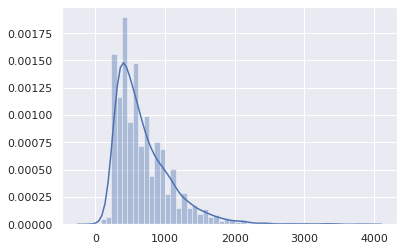

In [108]:
x = np.array(lengths)
sns.distplot(x)

In [109]:
np.mean(x)

694.8551236749116

In [110]:
np.percentile(x, 95)

1501.0

### Построение выборки

Центрируем районы с участками триплксных DNA:

In [654]:
!awk 'BEGIN{ OFS="\t"; }{ len=$3-$2; center=$2+int(len/2); flank=750; print $1, center-flank, center+flank; }' GSM3417036_TriplexDNASeq_plus_RNA_ligation.bed  > pos.bed

In [655]:
!bedtools2/bin/bedtools getfasta -fi GRCh38.p5.genome.fa -bed pos.bed -fo gen_pos_outoput.fasta

Выбираем 3 тысячи рандомных участков DNA, не пересекающихся с триплексными участками:

In [656]:
!bedtools2/bin/bedtools random -g GRCh38.p5.genome.fa.fai -l 1500 -n 3000 -seed 71346 > random.bed

In [657]:
# Shift intervals, but do not place them in the foreground regions
!bedtools2/bin/bedtools shuffle -i random.bed -g GRCh38.p5.genome.fa.fai -excl GSM3417036_TriplexDNASeq_plus_RNA_ligation.bed > rand_pos_excl.bed

In [658]:
!bedtools2/bin/bedtools getfasta -fi GRCh38.p5.genome.fa -bed rand_pos_excl.bed -fo gen_rand_outoput.fasta

Извлекаем выборку для CNN и других моделей:

In [659]:
f = open("gen_pos_outoput.fasta", "r")
count_lines = 0

chromo_list = []
chromo = ""

while True:
    line = f.readline()
    
    if not line:
        break

    count_lines += 1
    
    if line[0] == ">":
        if "N" in chromo:
            chromo = ""
        if chromo:
            chromo_list.append(chromo[:-1])
        chromo = ""
    else:
        chromo += line
    
f.close()
if chromo:
    chromo_list.append(chromo[:-1])

lengths = [len(x) for x in chromo_list]
print("Кол-во строк в файле:", count_lines)
print("Кол-во объектов в выборке:", len(chromo_list))
print("Длина одного объекта:", len(chromo_list[0]))

onehot_dict = {
    "A" : [1, 0, 0, 0],
    "C" : [0, 1, 0, 0],
    "T" : [0, 0, 1, 0],
    "G" : [0, 0, 0, 1]
}

count = 0

X_cnn_true = np.zeros((len(chromo_list), len(chromo_list[0]), 4))
for i in range(len(chromo_list)):
    for j in range(len(chromo_list[0])):
        if chromo_list[i][j] == 'A':
            X_cnn_true[i, j, 0] = 1
        elif chromo_list[i][j] == 'C':
            X_cnn_true[i, j, 1] = 1
        elif chromo_list[i][j] == 'T':
            X_cnn_true[i, j, 2] = 1
        elif chromo_list[i][j] == 'G':
            X_cnn_true[i, j, 3] = 1
        elif chromo_list[i][j] == 'N':
            count += 1

print("Check one-hot:", int(np.sum(X_cnn_true)), count)

dinucleotide = dict.fromkeys([''.join(x) for x in list(product('ACTG', 'ACTG'))], 0)
nucleotide_triplets = dict.fromkeys([''.join(x) for x in list(product('ACTG', 'ACTG', 'ACTG'))], 0)

X_true = np.zeros((len(chromo_list), 80))

for i in range(len(chromo_list)):
    for j in range(len(chromo_list[0]) - 1):
        dinucleotide[chromo_list[i][j:j+2]] += 1
    for j in range(len(chromo_list[0]) - 2):
        nucleotide_triplets[chromo_list[i][j:j+3]] += 1
    dinucleotide = [dinucleotide[key] for key in sorted(dinucleotide.keys())]
    nucleotide_triplets = [nucleotide_triplets[key] for key in sorted(nucleotide_triplets.keys())]
    
    X_true[i, :16] = dinucleotide
    X_true[i, 16:] = nucleotide_triplets
    
    dinucleotide = dict.fromkeys([''.join(x) for x in list(product('ACTG', 'ACTG'))], 0)
    nucleotide_triplets = dict.fromkeys([''.join(x) for x in list(product('ACTG', 'ACTG', 'ACTG'))], 0)

print("Check nucleos:", int(np.sum(X_true[i, :16])), int(np.sum(X_true[i, 16:]))) 

Кол-во строк в файле: 5094
Кол-во объектов в выборке: 2533
Длина одного объекта: 1500
Check one-hot: 3799500 0
Check nucleos: 1499 1498


In [660]:
f = open("gen_rand_outoput.fasta", "r")
count_lines = 0

chromo_list = []
chromo = ""

while True:
    line = f.readline()
    
    if not line:
        break

    count_lines += 1
    
    if line[0] == ">":
        if "N" in chromo:
            chromo = ""
        if chromo:
            chromo_list.append(chromo[:-1])
        chromo = ""
    else:
        chromo += line
    
f.close()
if chromo:
    chromo_list.append(chromo[:-1])

lengths = [len(x) for x in chromo_list]
print("Кол-во строк в файле:", count_lines)
print("Кол-во объектов в выборке:", len(chromo_list))
print("Длина одного объекта:", len(chromo_list[0]))

onehot_dict = {
    "A" : [1, 0, 0, 0],
    "C" : [0, 1, 0, 0],
    "T" : [0, 0, 1, 0],
    "G" : [0, 0, 0, 1]
}

count = 0

X_cnn_neg = np.zeros((len(chromo_list), len(chromo_list[0]), 4))
for i in range(len(chromo_list)):
    for j in range(len(chromo_list[0])):
        if chromo_list[i][j] == 'A':
            X_cnn_neg[i, j, 0] = 1
        elif chromo_list[i][j] == 'C':
            X_cnn_neg[i, j, 1] = 1
        elif chromo_list[i][j] == 'T':
            X_cnn_neg[i, j, 2] = 1
        elif chromo_list[i][j] == 'G':
            X_cnn_neg[i, j, 3] = 1
        elif chromo_list[i][j] == 'N':
            count += 1

print("Check one-hot:", int(np.sum(X_cnn_neg)), count)

dinucleotide = dict.fromkeys([''.join(x) for x in list(product('ACTG', 'ACTG'))], 0)
nucleotide_triplets = dict.fromkeys([''.join(x) for x in list(product('ACTG', 'ACTG', 'ACTG'))], 0)

X_neg = np.zeros((len(chromo_list), 80))

for i in range(len(chromo_list)):
    for j in range(len(chromo_list[0]) - 1):
        dinucleotide[chromo_list[i][j:j+2]] += 1
    for j in range(len(chromo_list[0]) - 2):
        nucleotide_triplets[chromo_list[i][j:j+3]] += 1
    dinucleotide = [dinucleotide[key] for key in sorted(dinucleotide.keys())]
    nucleotide_triplets = [nucleotide_triplets[key] for key in sorted(nucleotide_triplets.keys())]
    
    X_neg[i, :16] = dinucleotide
    X_neg[i, 16:] = nucleotide_triplets
    
    dinucleotide = dict.fromkeys([''.join(x) for x in list(product('ACTG', 'ACTG'))], 0)
    nucleotide_triplets = dict.fromkeys([''.join(x) for x in list(product('ACTG', 'ACTG', 'ACTG'))], 0)

print("Check nucleos:", int(np.sum(X_neg[i, :16])), int(np.sum(X_neg[i, 16:]))) 

Кол-во строк в файле: 6000
Кол-во объектов в выборке: 2854
Длина одного объекта: 1500
Check one-hot: 4281000 0
Check nucleos: 1499 1498


In [661]:
X_cnn = np.concatenate((X_cnn_true, X_cnn_neg), axis=0)
y_cnn = np.concatenate((np.ones((X_cnn_true.shape[0])), np.zeros((X_cnn_neg.shape[0]))), axis=0)

X = np.concatenate((X_true, X_neg), axis=0)
y = np.concatenate((np.ones((X_true.shape[0])), np.zeros((X_neg.shape[0]))), axis=0)

print("Shape check:", X_cnn.shape, X.shape)
print("Positive check:", int(np.sum(y_cnn)), int(np.sum(y)))

Shape check: (5387, 1500, 4) (5387, 80)
Positive check: 2533 2533


Делим выборки на обучающую и тестовую:

In [662]:
X_cnn_train, X_cnn_test, y_cnn_train, y_cnn_test = train_test_split(X_cnn, y_cnn, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Логистическая регрессия

ROC-AUC: 0.780, ACC: 0.719
Log Loss: 0.568
              precision    recall  f1-score   support

         0.0       0.72      0.75      0.74       851
         1.0       0.71      0.68      0.70       766

    accuracy                           0.72      1617
   macro avg       0.72      0.72      0.72      1617
weighted avg       0.72      0.72      0.72      1617



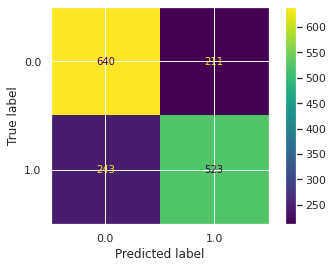

In [667]:
cv = ShuffleSplit(n_splits=1, test_size=0.3)
X_norm = X / np.linalg.norm(X) * 100
for train_ids, test_ids in cv.split(X_norm):
    lr = LogisticRegression(max_iter=100)
    lr.fit(X_norm[train_ids], y[train_ids])
    preds = lr.predict_proba(X_norm[test_ids])[:,1]
    print('ROC-AUC: %.3f, ACC: %.3f' % (roc_auc_score(y[test_ids], preds), 
                                        accuracy_score(y[test_ids], (preds > 0.5).astype(int))))
    print('Log Loss: %.3f' % (log_loss(y[test_ids], preds)))
    y_pred = lr.predict(X_norm[test_ids])
    print(classification_report(y[test_ids], y_pred))
    disp = plot_confusion_matrix(lr, X_norm[test_ids], y[test_ids])

## Решающие деревья

ROC-AUC: 0.788, ACC: 0.714
Log Loss: 0.554
              precision    recall  f1-score   support

         0.0       0.72      0.74      0.73       842
         1.0       0.71      0.69      0.70       775

    accuracy                           0.71      1617
   macro avg       0.71      0.71      0.71      1617
weighted avg       0.71      0.71      0.71      1617

TEST:
Confusion matrix:
   |  +  |  - 
 + | 532|  219
 - |  243| 623
TPR: 0.686
TNR: 0.740
PPV: 0.708
NPV: 0.719
Accuracy: 0.714
F1 score: 0.697


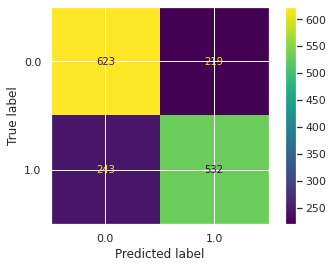

In [668]:
cv = ShuffleSplit(n_splits=1, test_size=0.3)
X_norm = X
for train_ids, test_ids in cv.split(X_norm):
    lr = RandomForestClassifier(n_estimators=100)
    lr.fit(X_norm[train_ids], y[train_ids])
    preds = lr.predict_proba(X_norm[test_ids])[:, 1]
    print('ROC-AUC: %.3f, ACC: %.3f' % (roc_auc_score(y[test_ids], preds), 
                                        accuracy_score(y[test_ids], (preds > 0.5).astype(int))))
    print('Log Loss: %.3f' % (log_loss(y[test_ids], preds)))
    y_pred = lr.predict(X_norm[test_ids])
    print(classification_report(y[test_ids], y_pred))
    disp = plot_confusion_matrix(lr, X_norm[test_ids], y[test_ids])
    
    print("TEST:")
    
    pred = y_pred
    target = y[test_ids]
    
    tp = np.sum(np.logical_and(np.array(np.equal(pred, target)).astype(bool), pred == 1))
    tn = np.sum(np.logical_and(np.array(np.equal(pred, target)).astype(bool), pred == 0))
    fp = np.sum(np.logical_and(np.array(np.not_equal(pred, target)).astype(bool), pred == 1))
    fn = np.sum(np.logical_and(np.array(np.not_equal(pred, target)).astype(bool), pred == 0))
    
    print("Confusion matrix:")
    print("   |  +  |  - ")
    print(" + | ", tp ,"|  ", fp, sep='')
    print(" - |  ", fn ,"| ", tn, sep='')

    TPR = tp/(tp + fn)
    TNR = tn/(tn + fp)
    PPV = tp/(tp + fp)
    NPV = tn/(tn + fn)

    print("TPR: %.3f" % TPR)
    print("TNR: %.3f" % TNR)
    print("PPV: %.3f" % PPV)
    print("NPV: %.3f" % NPV)

    acc = (tp + tn) / (tp + tn + fp + fn)
    f1_score = 2 * tp / (2*tp + fp + fn)

    print("Accuracy: %.3f" % acc)
    print("F1 score: %.3f" % f1_score)

## Multi-layer Perceptron classifier

ROC-AUC: 0.972, ACC: 0.915
Log Loss: 0.277
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      1437
         1.0       0.91      0.91      0.91      1257

    accuracy                           0.91      2694
   macro avg       0.91      0.91      0.91      2694
weighted avg       0.91      0.91      0.91      2694



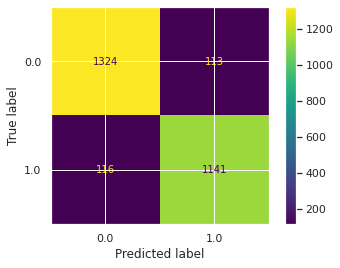

In [675]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                hidden_layer_sizes=(5, 2), random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
clf.fit(X_train, y_train)

preds = lr.predict_proba(X_test)[:, 1]
print('ROC-AUC: %.3f, ACC: %.3f' % (roc_auc_score(y_test, preds), 
        accuracy_score(y_test, (preds > 0.5).astype(int))))
print('Log Loss: %.3f' % (log_loss(y_test, preds)))
    

pred = lr.predict(X_test)
target = y_test
print(classification_report(target, pred))

plot_confusion_matrix(lr, X_test, y_test)

In [677]:
tp = np.sum(np.logical_and(np.array(np.equal(pred, target)).astype(bool), pred == 1))
tn = np.sum(np.logical_and(np.array(np.equal(pred, target)).astype(bool), pred == 0))
fp = np.sum(np.logical_and(np.array(np.not_equal(pred, target)).astype(bool), pred == 1))
fn = np.sum(np.logical_and(np.array(np.not_equal(pred, target)).astype(bool), pred == 0))

print("Confusion matrix:")
print("   | + | - ")
print(" + |", tp ,"|", fp, sep='')
print(" - |", fn ,"|", tn, sep='')

TPR = tp/(tp + fn)
TNR = tn/(tn + fp)
PPV = tp/(tp + fp)
NPV = tn/(tn + fn)

print("TPR: %.3f" % TPR)
print("TNR: %.3f" % TNR)
print("PPV: %.3f" % PPV)
print("NPV: %.3f" % NPV)

acc = (tp + tn) / (tp + tn + fp + fn)
f1_score = 2 * tp / (2*tp + fp + fn)

print("Accuracy: %.3f" % acc)
print("F1 score: %.3f" % f1_score)

Confusion matrix:
   | + | - 
 + |1141|113
 - |116|1324
TPR: 0.908
TNR: 0.921
PPV: 0.910
NPV: 0.919
Accuracy: 0.915
F1 score: 0.909


## NaiveBayes

In [669]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 2694 points : 889


In [670]:
pred = y_pred
target = y_test

tp = np.sum(np.logical_and(np.array(np.equal(pred, target)).astype(bool), pred == 1))
tn = np.sum(np.logical_and(np.array(np.equal(pred, target)).astype(bool), pred == 0))
fp = np.sum(np.logical_and(np.array(np.not_equal(pred, target)).astype(bool), pred == 1))
fn = np.sum(np.logical_and(np.array(np.not_equal(pred, target)).astype(bool), pred == 0))

print("Confusion matrix:")
print("   | + | - ")
print(" + |", tp ,"|", fp, sep='')
print(" - |", fn ,"|", tn, sep='')

TPR = tp/(tp + fn)
TNR = tn/(tn + fp)
PPV = tp/(tp + fp)
NPV = tn/(tn + fn)

print("TPR: %.3f" % TPR)
print("TNR: %.3f" % TNR)
print("PPV: %.3f" % PPV)
print("NPV: %.3f" % NPV)

acc = (tp + tn) / (tp + tn + fp + fn)
f1_score = 2 * tp / (2*tp + fp + fn)

print("Accuracy: %.3f" % acc)
print("F1 score: %.3f" % f1_score)

print("Loss: %.3f" % loss)

Confusion matrix:
   | + | - 
 + |627|259
 - |630|1178
TPR: 0.499
TNR: 0.820
PPV: 0.708
NPV: 0.652
Accuracy: 0.670
F1 score: 0.585
Loss: 0.619


## CNN -- ResNet (предобученные веса)

In [81]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from torch.utils import data

tensor_x = torch.Tensor(np.expand_dims(X_cnn_train, axis=1)).view(3609, 3, 500, 4).type(torch.FloatTensor) # transform to torch tensor
tensor_y = torch.Tensor(y_cnn_train).type(torch.LongTensor)

my_dataset = data.TensorDataset(tensor_x,tensor_y) # create your datset
train_load = data.DataLoader(my_dataset,
                            batch_size = 250,
                            shuffle = True) # create your dataloader

test_tensor_x = torch.Tensor(np.expand_dims(X_cnn_test, axis=1)).view(1778, 3, 500, 4).type(torch.FloatTensor) # transform to torch tensor
test_tensor_y = torch.Tensor(y_cnn_test).type(torch.LongTensor)

my_test_dataset = data.TensorDataset(test_tensor_x,test_tensor_y) # create your datset
test_load = data.DataLoader(my_test_dataset,
                            batch_size = 250,
                            shuffle = True) # create your dataloader


dataloaders = {'train': train_load, 'val': test_load}
dataset_sizes = {'train': len(X_cnn_train), 'val': len(X_cnn_test)}

use_gpu = torch.cuda.is_available()
plt.ion()

In [82]:
# обратите внимание на сохранение лучшей версии весов сети
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels).type(torch.float)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        time_elapsed = time.time() - since
        print('Elapsed {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [83]:
model_ft = models.resnet18(pretrained=True)

model_ft.fc = nn.Linear(in_features=512, out_features=2, bias=True)

params_to_train = []
for name, param in model_ft.named_parameters():
    if name[:2] == 'fc':
        params_to_train.append(param)
        param.requires_grad = True
    else:
        param.requires_grad = False

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(params_to_train, lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0030 Acc: 0.5021
val Loss: 0.0032 Acc: 0.5169
Elapsed 0m 27s

Epoch 1/24
----------
train Loss: 0.0029 Acc: 0.5456
val Loss: 0.0032 Acc: 0.5028
Elapsed 0m 54s

Epoch 2/24
----------
train Loss: 0.0028 Acc: 0.5816
val Loss: 0.0032 Acc: 0.5360
Elapsed 1m 21s

Epoch 3/24
----------
train Loss: 0.0027 Acc: 0.6076
val Loss: 0.0030 Acc: 0.5894
Elapsed 1m 48s

Epoch 4/24
----------
train Loss: 0.0027 Acc: 0.6240
val Loss: 0.0029 Acc: 0.6057
Elapsed 2m 15s

Epoch 5/24
----------
train Loss: 0.0027 Acc: 0.6331
val Loss: 0.0030 Acc: 0.6091
Elapsed 2m 42s

Epoch 6/24
----------
train Loss: 0.0027 Acc: 0.6409
val Loss: 0.0030 Acc: 0.6085
Elapsed 3m 9s

Epoch 7/24
----------
train Loss: 0.0027 Acc: 0.6437
val Loss: 0.0029 Acc: 0.6052
Elapsed 3m 36s

Epoch 8/24
----------
train Loss: 0.0026 Acc: 0.6431
val Loss: 0.0030 Acc: 0.6091
Elapsed 4m 3s

Epoch 9/24
----------
train Loss: 0.0026 Acc: 0.6453
val Loss: 0.0030 Acc: 0.6108
Elapsed 4m 30s

Epoch 10/24
----------

## CNN

Перед запуском дальнейшего кода нужно уменьшить область наблюдаемых нуклеотидов до 500. Поскольку выборка маленькая, большое число параметров не сможет нормально обучиться на такой выборке.

In [548]:
X_cnn_train = X_cnn_train / np.linalg.norm(X_cnn_train) * 100
X_cnn_test = X_cnn_test / np.linalg.norm(X_cnn_test) * 100

In [549]:
from tqdm import trange
import torch.nn.functional as F
from IPython.display import clear_output

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def train_epoch(model, optimizer, batchsize=100):
    loss_log, acc_log = [], []
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_cnn_train, y_cnn_train, batchsize=batchsize, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)
        
        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for x_batch, y_batch in iterate_minibatches(X_cnn_test, y_cnn_test, batchsize=100, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        output = model(data)
        loss = F.nll_loss(output, target)
        
        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    batchsize = 32

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        train_loss, train_acc = train_epoch(model, opt, batchsize=batchsize)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(X_cnn_train) / batchsize
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')
        print("Epoch {} error = {:.2%}".format(epoch, 1 - val_acc_log[-1][1]))
            
    print("Final error: {:.2%}".format(1 - val_acc_log[-1][1]))
    return (1 - val_acc_log[-1][1])

In [584]:
class otladka(nn.Module):
    def forward(self, x):
        print(x.shape)
        return x

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()        
        
        self.features = nn.Sequential(
            nn.Conv1d(500, 10, (1, 4), padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(3)
        )
        
        self.classifier = nn.Linear(10, 2)
        
    def forward(self, x):
        ft = self.features(x.view(-1, 500, 1, 4))
        out = self.classifier(ft.view(-1, 10))
        return F.log_softmax(out, dim=-1)

In [595]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

model = ConvNet()
print("Total number of trainable parameters:", count_parameters(model))

Total number of trainable parameters: 20032


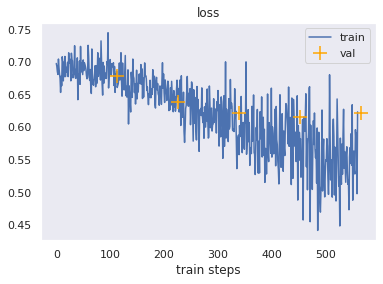

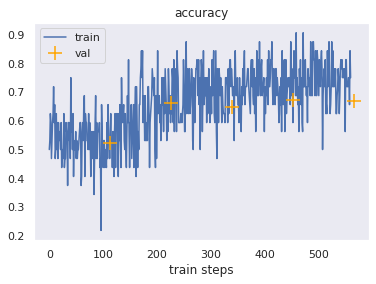

Epoch 4 error = 33.06%
Final error: 33.06%
CPU times: user 9.26 s, sys: 2.79 s, total: 12 s
Wall time: 6.07 s


In [596]:
%%time

opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
train(model, opt, 5)

In [597]:
data = torch.from_numpy(X_cnn_test.astype(np.float32))
target = torch.from_numpy(y_cnn_test.astype(np.int64))

output = model(data)
loss = F.nll_loss(output, target)        
pred = torch.max(output, 1)[1].numpy()

In [600]:
tp = np.sum(np.logical_and(np.array(np.equal(pred, target)).astype(bool), pred == 1))
tn = np.sum(np.logical_and(np.array(np.equal(pred, target)).astype(bool), pred == 0))
fp = np.sum(np.logical_and(np.array(np.not_equal(pred, target)).astype(bool), pred == 1))
fn = np.sum(np.logical_and(np.array(np.not_equal(pred, target)).astype(bool), pred == 0))

print("Confusion matrix:")
print("   | + | - ")
print(" + |", tp ,"|", fp, sep='')
print(" - |", fn ,"|", tn, sep='')

TPR = tp/(tp + fn)
TNR = tn/(tn + fp)
PPV = tp/(tp + fp)
NPV = tn/(tn + fn)

print("TPR: %.3f" % TPR)
print("TNR: %.3f" % TNR)
print("PPV: %.3f" % PPV)
print("NPV: %.3f" % NPV)

acc = (tp + tn) / (tp + tn + fp + fn)
f1_score = 2 * tp / (2*tp + fp + fn)

print("Accuracy: %.3f" % acc)
print("F1 score: %.3f" % f1_score)

print("Loss: %.3f" % loss)

Confusion matrix:
   | + | - 
 + |561|291
 - |295|634
TPR: 0.655
TNR: 0.685
PPV: 0.658
NPV: 0.682
Accuracy: 0.671
F1 score: 0.657
Loss: 0.619
